In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from figurefirst import mpl_functions
import seaborn as sns

from mpl_toolkits.axes_grid1 import make_axes_locatable 
import odor_stat_calculations as osc
from scipy.spatial.distance import cdist
import scipy.stats as st
from sklearn.preprocessing import StandardScaler

## training
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:

def scale_data(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (((data - min_val) / (max_val - min_val)) * 10)

In [3]:
# class LogNormalNN(nn.Module):
#     def __init__(self, input_size, hidden_dim):
#         super(LogNormalNN, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_dim)
#         self.fc2 = nn.Linear(hidden_dim, 2)
        
#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         log_mu, log_var = x[:, 0], x[:, 1]
#         return log_mu, log_var

# def gaussian_nll(mu, log_var, x):
#     return 0.5 * (log_var + (x - mu)**2 / torch.exp(log_var)).mean()

# def load_and_preprocess_file(file_path, features, target):
#     df = pd.read_hdf(file_path)
#     # df[target] = np.log(df[target] + 1e-6) 
#     # df[target] = np.log(np.clip(df[target], a_min=1e-6, a_max=None))

#     scaler = MinMaxScaler()
#     df[features] = scaler.fit_transform(df[features])
    
#     feature_tensors = torch.Tensor(df[features].values)
#     target_tensors = torch.Tensor(df[target].values)

#     feature_tensors = feature_tensors.view(-1, len(features))
#     return feature_tensors, target_tensors

# def create_sequences(feature_tensors, target_tensors, seq_length):
#     sequences = []
#     targets = []
#     for i in range(len(feature_tensors) - seq_length):
#         sequences.append(feature_tensors[i:i+seq_length])
#         targets.append(target_tensors[i+seq_length])
#     return torch.stack(sequences), torch.stack(targets)

# def train_on_single_file_faster(model, optimizer, criterion, sequences, targets, num_epochs, device):
#     model.train()
#     log_targets = torch.log(targets + 1e-6)
    
#     for epoch in range(num_epochs):
#         optimizer.zero_grad()
        
#         flattened_sequences = sequences.view(sequences.size(0), -1).float().to(device)
#         log_targets = log_targets.float().to(device)
        
#         mu, log_var = model(flattened_sequences)
#         loss = criterion(mu, log_var, log_targets.squeeze())
        
#         loss.backward()
        
#         # Gradient Clipping
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        
#         optimizer.step()
        
#         if (epoch + 1) % 100 == 0:
#             print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')

# def predict_on_new_data(model, new_data_path, features, target, seq_length, device):
#     feature_tensors, target_tensors = load_and_preprocess_file(new_data_path, features, target)
#     sequences, _ = create_sequences(feature_tensors, target_tensors, seq_length)
#     sequences = sequences.to(device)
#     model.eval()

#     with torch.no_grad():
#         mu, log_var = model(sequences.view(sequences.size(0), -1))
#         mu_preds = mu.cpu().numpy()  # No longer applying torch.exp to mu
#         var_preds = torch.exp(log_var).cpu().numpy()  # Use exponential to convert log var to var
#     return mu_preds, var_preds




In [4]:
class MDN(nn.Module):
    def __init__(self, input_size, hidden_dim, n_gaussians):
        super(MDN, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_dim)
        
        # Mixture weights (pi's)
        self.pi = nn.Linear(hidden_dim, n_gaussians)
        
        # Means (mu's)
        self.mu = nn.Linear(hidden_dim, n_gaussians)
        
        # Variances (sigma's)
        self.sigma = nn.Linear(hidden_dim, n_gaussians)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        
        pi = F.softmax(self.pi(x), dim=1)
        mu = self.mu(x)
        sigma = torch.exp(self.sigma(x))  # Ensure sigma is positive
        
        return pi, mu, sigma

def mdn_loss(pi, mu, sigma, target):
    m = torch.distributions.Normal(loc=mu, scale=sigma)
    log_prob = m.log_prob(target.unsqueeze(1))
    log_pi = torch.log(pi)
    
    # LogSumExp trick to prevent underflow/overflow
    max_log_prob = log_prob.max(1, keepdim=True)[0]
    log_sum_exp = max_log_prob + torch.log(torch.exp(log_prob - max_log_prob).sum(1, keepdim=True))
    log_likelihood = log_sum_exp + log_pi
    loss = -log_likelihood.sum()
    return loss


def load_and_preprocess_file(file_path, features, target):
    df = pd.read_hdf(file_path)
    # df[target] = np.log(df[target] + 1e-6) 
    # df[target] = np.log(np.clip(df[target], a_min=1e-6, a_max=None))

    scaler = StandardScaler()
    df[features] = scaler.fit_transform(df[features])
    
    feature_tensors = torch.Tensor(df[features].values)
    target_tensors = torch.Tensor(df[target].values)

    feature_tensors = feature_tensors.view(-1, len(features))
    return feature_tensors, target_tensors


def predict_on_new_data_mdn(model, file_path, features, target, seq_length, device):
    model.eval()
    feature_tensors, target_tensors = load_and_preprocess_file(file_path, features, target)
    sequences, _ = create_sequences(feature_tensors, target_tensors, seq_length)
    
    with torch.no_grad():
        sequences = sequences.to(device)
        flattened_sequences = sequences.view(sequences.size(0), -1).float()
        pi, mu, sigma = model(flattened_sequences)
        
        # Computing the expected value
        expected_val = (pi * mu).sum(dim=1).cpu().numpy()
        
    return expected_val

def train_on_single_file_faster(model, optimizer, sequences, targets, num_epochs, device):
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        
        pi, mu, sigma = model(sequences.view(sequences.size(0), -1))
        loss = mdn_loss(pi, mu, sigma, targets.squeeze())
        
        loss.backward()
        optimizer.step()
        
        # Optional: print epoch and loss
        if (epoch + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


In [5]:
input_size = 2  
hidden_dim = 128
num_epochs = 600
seq_length = 5 
n_gaussians = 5  # Number of Gaussians in the mixture. Adjust as needed.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_mdn = MDN(input_size = 2, hidden_dim = hidden_dim, n_gaussians=5).to(device)
optimizer = optim.Adam(model_mdn.parameters(), lr=0.001)

features = ['distance_along_streakline', 'nearest_from_streakline']
target = ['odor']

filepath = "/home/beast/An/data/Sept13Plumes/plume1/train/"

# scaler = StandardScaler()
# features_normalized = scaler.fit_transform(features)


for file in os.listdir(filepath):
    file_path = os.path.join(filepath, file)
    feature_tensors, target_tensors = load_and_preprocess_file(file_path, features, target)
    sequences, targets = create_sequences(feature_tensors, target_tensors, seq_length)
    
    sequences = sequences.to(device)
    targets = targets.to(device)
    
    train_on_single_file_faster(model_mdn, optimizer, sequences, targets, num_epochs, device)


ValueError: could not convert string to float: 'distance_along_streakline'

Mean Squared Error on Test Data: 0.1810561567544937


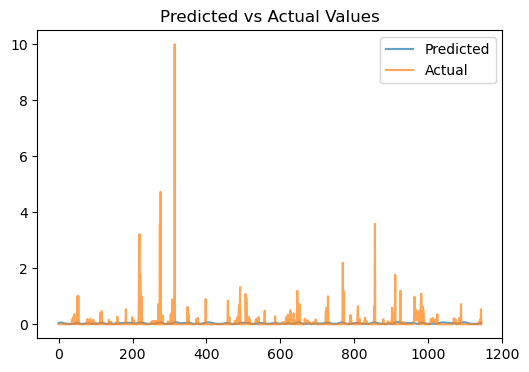

In [51]:
fp="/home/beast/An/data/Sept13Plumes/plume1/train/diag21.h5"

expected_preds_test = predict_on_new_data_mdn(model_mdn, fp, features, target, seq_length, device)

# 2. Load and preprocess the test data again to get targets (to compute MSE and for plotting)
feature_tensors_test, target_tensors_test = load_and_preprocess_file(fp, features, target)
_, targets_test = create_sequences(feature_tensors_test, target_tensors_test, seq_length)
targets_test_np = targets_test.cpu().numpy().squeeze()

# 3. Evaluation
# Compute Mean Squared Error (MSE) between predicted expected values and actual targets
mse = ((expected_preds_test - targets_test_np) ** 2).mean()
print(f'Mean Squared Error on Test Data: {mse}')

plt.figure(figsize=(6, 4))
plt.plot(expected_preds_test, label='Predicted', alpha=0.7)
plt.plot(targets_test_np, label='Actual', alpha=0.7)
plt.legend()
plt.title('Predicted vs Actual Values')
plt.show()


In [52]:

# input_size = 2  
# hidden_dim = 128
# num_epochs = 400
# seq_length = 5 
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model_gaussian = LogNormalNN(input_size * seq_length, hidden_dim).to(device)
# optimizer = optim.Adam(model_gaussian.parameters(), lr=0.009)
# criterion = gaussian_nll

# # Add learning rate scheduler
# # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

# features = ['distance_along_streakline','nearest_from_streakline']
# target = ['odor']

# filepath="/home/beast/An/data/Sept13Plumes/plume1/train/"
# for file in os.listdir(filepath):
#     file_path = os.path.join(filepath, file)
#     feature_tensors, target_tensors = load_and_preprocess_file(file_path, features, target)
#     sequences, targets = create_sequences(feature_tensors, target_tensors, seq_length)
    
#     sequences = sequences.to(device)
#     targets = targets.to(device)
    
#     train_on_single_file_faster(model_gaussian, optimizer, criterion, sequences, targets, num_epochs, device)
#     # scheduler.step()  # Step the learning rate scheduler each epoch

In [53]:
# f,ax=plt.subplots(1,1,figsize=(4,4))
# sns.distplot(targets_test_np, kde=True,ax=ax, label='test',color='r')
# sns.distplot(scale_data(mu_preds_test), kde=True, ax=ax, label='pred', color='b')
# # ax.set_xlim(0,2)
# # ax.set_ylim(0,30)

Mean Squared Error on Test Data: 173.06427001953125


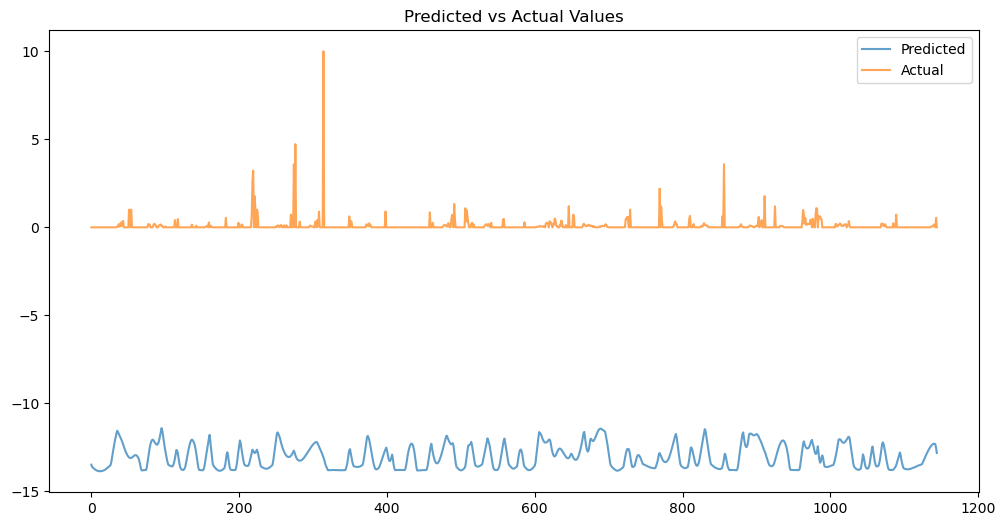

In [20]:
fp="/home/beast/An/data/Sept13Plumes/plume1/train/diag21.h5"
# 
# mu_preds, var_preds = predict_on_new_data(model_gaussian, fp, features, target, seq_length, device)

mu_preds_test, var_preds_test = predict_on_new_data(model_gaussian, fp, features, target, seq_length, device)

# 2. Load and preprocess the test data again to get targets (to compute MSE and for plotting)
feature_tensors_test, target_tensors_test = load_and_preprocess_file(fp, features, target)
_, targets_test = create_sequences(feature_tensors_test, target_tensors_test, seq_length)
targets_test_np = targets_test.cpu().numpy().squeeze()

# 3. Evaluation
# Compute Mean Squared Error (MSE) between predicted mu and actual targets
mse = ((mu_preds_test - targets_test_np) ** 2).mean()
print(f'Mean Squared Error on Test Data: {mse}')


plt.figure(figsize=(12, 6))
plt.plot(mu_preds_test, label='Predicted', alpha=0.7)
plt.plot(targets_test_np, label='Actual', alpha=0.7)
plt.legend()
plt.title('Predicted vs Actual Values')
plt.show()


Text(0.5, 1.0, 'Actual Values')

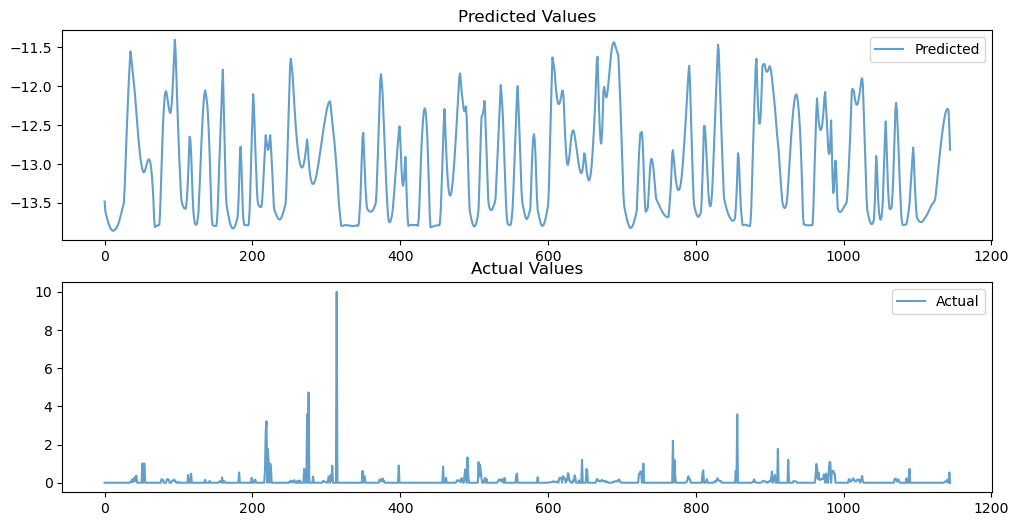

In [21]:
f, ax = plt.subplots(2, 1, figsize=(12, 6))

# Plot Predicted Values
ax[0].plot(mu_preds_test, label='Predicted', alpha=0.7)
ax[0].legend()
ax[0].set_title('Predicted Values')

# Plot Actual Values
ax[1].plot(targets_test_np, label='Actual', alpha=0.7)
ax[1].legend()
ax[1].set_title('Actual Values')


In [14]:
_, actual_targets = load_and_preprocess_file(fp, features, target)

# Ensure actual_targets is a 1D numpy array
actual_targets = actual_targets.cpu().numpy().squeeze()

# Get predictions
mu_preds, var_preds = predict_on_new_data(model_gaussian, fp, features, target, seq_length, device)

# Create a time axis
time_axis = np.arange(len(actual_targets))


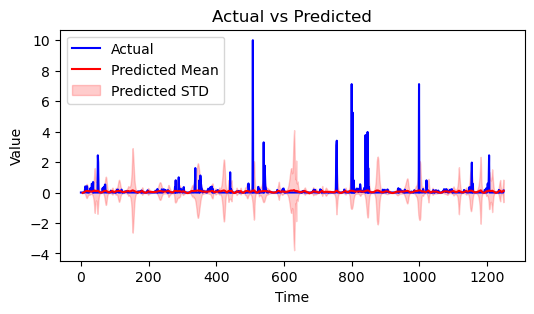

In [15]:
f, ax = plt.subplots(1, 1, figsize=(6, 3))

ax.plot(time_axis, actual_targets, label='Actual', color='blue')

ax.plot(time_axis[seq_length:], mu_preds, label='Predicted Mean', color='red')

ax.fill_between(time_axis[seq_length:], 
                mu_preds - np.sqrt(var_preds), 
                mu_preds + np.sqrt(var_preds), 
                color='red', alpha=0.2, label='Predicted STD')

ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.set_title('Actual vs Predicted')
ax.legend()

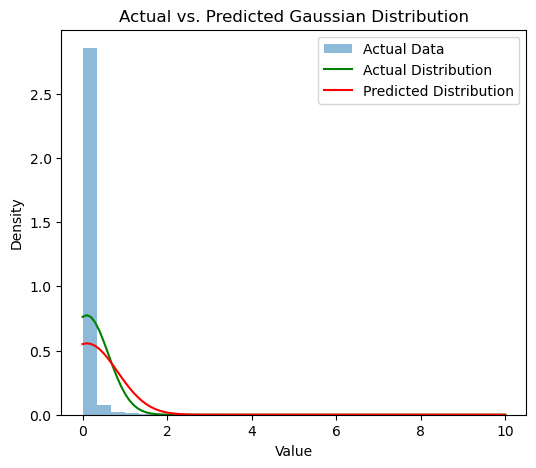

In [16]:
# Ensure predictions are numpy arrays for plotting
mu_preds = mu_preds.squeeze()
var_preds = var_preds.squeeze()

# Select a specific prediction (e.g., the last one)
selected_mu_pred = mu_preds[-1]
selected_var_pred = var_preds[-1]

# Generate a grid of values
x_vals = np.linspace(min(actual_targets), max(actual_targets), 100)

# Calculate the actual mean and variance of your target data
actual_mu = np.mean(actual_targets)
actual_var = np.var(actual_targets)

# Generate the Gaussian distributions
predicted_dist = (1 / (np.sqrt(2 * np.pi * selected_var_pred))) * np.exp(- (x_vals - selected_mu_pred)**2 / (2 * selected_var_pred))
actual_dist = (1 / (np.sqrt(2 * np.pi * actual_var))) * np.exp(- (x_vals - actual_mu)**2 / (2 * actual_var))

# Plotting using subplots style
f, ax = plt.subplots(1, 1, figsize=(6, 5))

# Histogram of actual targets
ax.hist(actual_targets, bins=30, density=True, alpha=0.5, label="Actual Data")

# Actual and predicted Gaussian distributions
ax.plot(x_vals, actual_dist, 'g', label="Actual Distribution")
ax.plot(x_vals, predicted_dist, 'r', label="Predicted Distribution")

ax.set_title("Actual vs. Predicted Gaussian Distribution")
ax.set_xlabel("Value")
ax.set_ylabel("Density")
ax.legend()


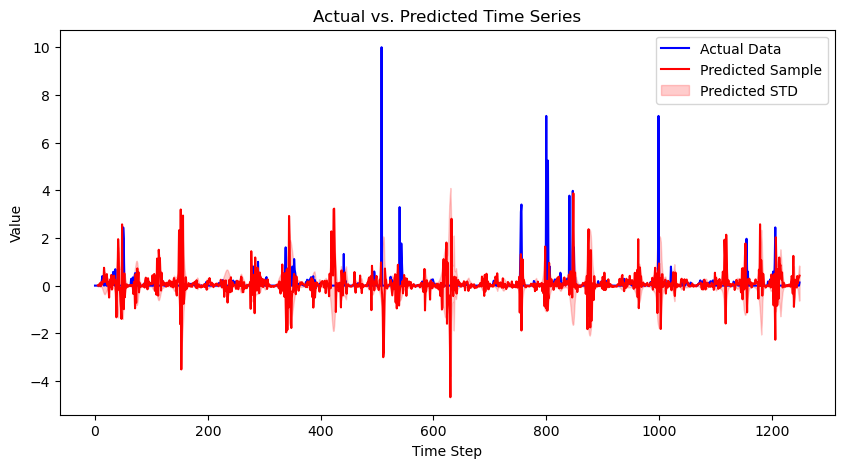

In [20]:
np.random.seed(0)  # for reproducibility
predicted_sample = np.random.normal(mu_preds, np.sqrt(var_preds))

# Plotting using subplots style
f, ax = plt.subplots(1, 1, figsize=(10, 5))

# Plotting the actual targets and predicted sample
ax.plot(actual_targets, 'b', label="Actual Data")
ax.plot(np.arange(seq_length, seq_length+len(predicted_sample)), 
        predicted_sample, 'r', label="Predicted Sample")

# Shading the predicted standard deviation
ax.fill_between(np.arange(seq_length, seq_length+len(predicted_sample)), 
                mu_preds - np.sqrt(var_preds), 
                mu_preds + np.sqrt(var_preds), 
                color='red', alpha=0.2, label='Predicted STD')

ax.set_title("Actual vs. Predicted Time Series")
ax.set_xlabel("Time Step")
ax.set_ylabel("Value")
ax.legend()

In [25]:
test=pd.read_hdf(fp)

In [28]:
padding_length = len(test) - len(predicted_sample)

# Pad zeros at the end of predicted_sample
predicted_sample_padded = np.pad(predicted_sample, (0, padding_length), 'constant', constant_values=(0))

# Assign the padded array to your DataFrame
test['predicted_odor'] = predicted_sample_padded

In [29]:
# test['scaled_odor']=scale_data(test.odor)
query='odor>0.1'
df = test.query(query)
df.reset_index(drop=True, inplace=True)

query1='predicted_odor>0.1'
df1 = test.query(query1)
df1.reset_index(drop=True, inplace=True)

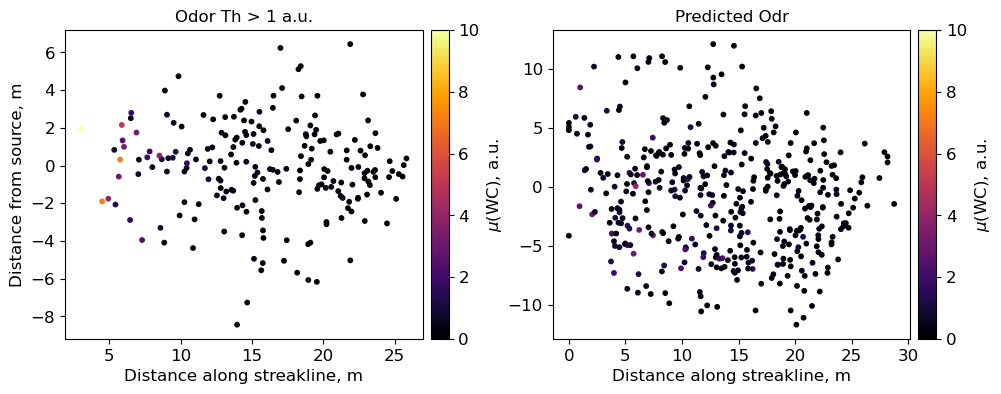

In [31]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
v = ax1.scatter(df.distance_along_streakline, df.nearest_from_streakline, c=df.odor, 
             s=10, cmap='inferno', vmin=0,vmax=10)

ax1.set_title('Odor Th > 1 a.u.')
ax1.set_ylabel('Distance from source, m')
ax1.set_xlabel('Distance along streakline, m')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(v, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.set_label('$\mu$(WC), a.u.')

w = ax2.scatter(df1.distance_along_streakline, df1.nearest_from_streakline, c=df1.predicted_odor, 
             s=10, cmap='inferno', vmin=0,vmax=10)

ax2.set_title('Predicted Odr')
# ax2.set_ylabel('Distance from source, m')
ax2.set_xlabel('Distance along streakline, m')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(w, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.set_label('$\mu$(WC), a.u.')

f.tight_layout(pad=1)
mpl_functions.set_fontsize(f, 12)